# Reinforment learning: Q-table learning

#### Reference:
https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

#### Bellman Equation: Q(s,a) = r + γ(max(Q(s’,a’))

## No neural network

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
env = gym.make('FrozenLake-v0')

[2017-09-03 14:33:35,875] Making new env: FrozenLake-v0


In [186]:
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning hyperparameters
lr = .8
y = .95
# Set how many times to play the game
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
for i in range(num_episodes):
    #Reset environment and get first new observation (state)
    s = env.reset()
    # total reward, only becomes 1 when the game is won
    rAll = 0
    # whether the game has finished (either won or lost)
    d = False
    # number of steps taken in this game
    j = 0
    #The Q-Table learning algorithm
    while j < 99: # break if game is not finished by 99 steps 
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state, reward (only 1 when game won), done or not, and info from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        # current value + learn rate * how much the new state is better than current value = updated current value
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    jList.append(j)
    rList.append(rAll)

Score over time: 0.433


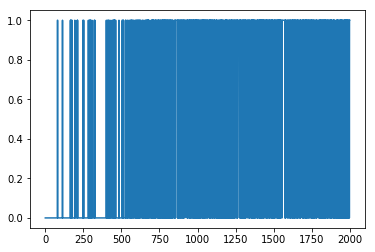

In [187]:
print("Score over time: " +  str(sum(rList)/num_episodes))
plt.plot(rList)
# print("Final Q-Table Values")
# print(Q)

#### ...seems to work fairly well, and consistently too

### I decided to try running code with proper epsilon-greediness...

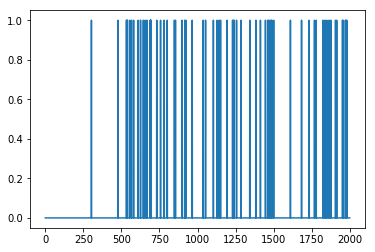

In [170]:
# Try this again, but with proper epsilon-greediness
Q = np.zeros([env.observation_space.n,env.action_space.n])
lr = .8
y = .95
# Set epsilon (chance of taking random action)
e = 0.4
num_episodes = 2000
jList = []
rList = []
for i in range(num_episodes):
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    while j < 99:
        j+=1
        a = np.argmax(Q[s,:])
        test = np.random.rand(1)
        if test < e:
            a = env.action_space.sample()
        s1,r,d,_ = env.step(a)
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    jList.append(j)
    rList.append(rAll)
    
plt.plot(rList)

#### ...which didn't work well. The value of epsilon affects outcome a lot. Maybe tweaking other hyperparameters would help?

### How about trying out SARSA?

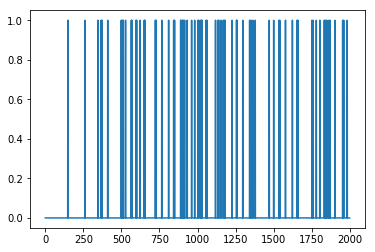

In [138]:
# Try this with SARSA (on-policy)
Q = np.zeros([env.observation_space.n,env.action_space.n])
lr = .8
y = .95
# Set epsilon (chance of taking random action)
e = 0.4
num_episodes = 2000
jList = []
rList = []
for i in range(num_episodes):
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    
    a = np.argmax(Q[s,:])
    if np.random.rand() < e:
        a = env.action_space.sample()
    while j < 99:
        j+=1
        s1,r,d,_ = env.step(a)
        a1 = np.argmax(Q[s1,:])
        if np.random.rand() < e:
            a1 = env.action_space.sample()
        Q[s,a] = Q[s,a] + lr*(r + y*Q[s1,a1] - Q[s,a])
        rAll += r
        s = s1
        a = a1
        if d == True:
            break
    jList.append(j)
    rList.append(rAll)
    
plt.plot(rList)

#### ...performance is still poor

## With neural network

In [179]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [180]:
env = gym.make('FrozenLake-v0')

[2017-09-03 15:17:50,287] Making new env: FrozenLake-v0


In [183]:
tf.reset_default_graph()

In [184]:
#These lines establish the feed-forward part of the network used to choose actions
# one-hot vector representing current state
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
# 1x4 vector representing available actions
Qout = tf.matmul(inputs1,W)
# index of action which has largest value
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [185]:
init = tf.global_variables_initializer() # depracated, update this part plz

# Set learning hyperparameters
y = .99
e = 0.1
num_episodes = 3000
#create lists to contain total rewards and steps per episode
jList = []
rList = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            # 1x1 vector a is index of "best" action, allQ is 1x4 vector of action values
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            # maxQ1 is value of new state
            maxQ1 = np.max(Q1)
            # targetQ is current 1x4 vector of action values
            targetQ = allQ
            # update value of chosen action, no need for subtraction like Q-table code
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")


Percent of succesful episodes: 0.24266666666666667%


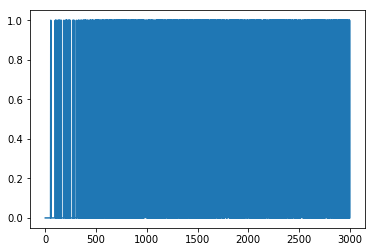

In [181]:
plt.plot(rList)

#### ...converges faster than vanilla Q-table method

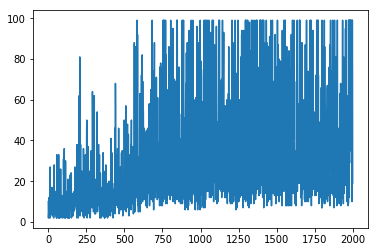

In [188]:
plt.plot(jList)